In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/music-data/jsb-chorales-quarter.json
/kaggle/input/music-data/Jsb16thSeparated.json
/kaggle/input/music-data/jsb-chorales-16th.json
/kaggle/input/music-data/jsb-chorales-8th.json


In [5]:
# ========================
# 1. Import dependencies
# ========================
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# ========================
# 2. Data Loading & Preprocessing
# ========================
def load_and_process_json_files(filenames):
    """Load and combine train/valid/test splits from multiple JSON files."""
    all_train, all_valid, all_test = [], [], []
    for file in filenames:
        with open(file) as f:
            data = json.load(f)
            all_train.extend(data.get("train", []))
            all_valid.extend(data.get("valid", []))
            all_test.extend(data.get("test", []))
    return all_train, all_valid, all_test

def data_process(song, min_pitch=21, max_pitch=108):
    """Convert a list of pitch values per timestep into binary piano roll vectors."""
    result = []
    for timestep in song:
        vec = np.zeros(max_pitch - min_pitch + 1, dtype=np.float32)
        for note in timestep:
            if isinstance(note, int) and min_pitch <= note <= max_pitch:
                vec[note - min_pitch] = 1
        result.append(vec)
    return np.stack(result) if result else np.zeros((1, max_pitch - min_pitch + 1), dtype=np.float32)

filenames = [
    "/kaggle/input/music-data/jsb-chorales-quarter.json",
    "/kaggle/input/music-data/Jsb16thSeparated.json",
    "/kaggle/input/music-data/jsb-chorales-16th.json",
    "/kaggle/input/music-data/jsb-chorales-8th.json"
]

train_raw, valid_raw, test_raw = load_and_process_json_files(filenames)
train_data = [data_process(song) for song in train_raw]
valid_data = [data_process(song) for song in valid_raw]
test_data  = [data_process(song) for song in test_raw]

# ========================
# 3. PyTorch Dataset & DataLoader
# ========================
class GRUData(Dataset):
    """Prepare sequences for autoregressive training."""
    def __init__(self, songs):
        self.samples = []
        for s in songs:
            if len(s) > 1:
                x, y = s[:-1], s[1:]
                self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def collate_fn(batch):
    """Pad sequences in the batch to the same length."""
    xs, ys = zip(*batch)
    return pad_sequence(xs, batch_first=True), pad_sequence(ys, batch_first=True)

batch_size = 32
train_loader = DataLoader(GRUData(train_data), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(GRUData(valid_data), batch_size=batch_size, collate_fn=collate_fn)

# ========================
# 4. Custom GRU Model
# ========================
class CustomGRUCell(nn.Module):
    """GRU cell with explicit reset, update, and candidate memory equations."""
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.W_z = nn.Linear(input_size, hidden_size)
        self.U_z = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_r = nn.Linear(input_size, hidden_size)
        self.U_r = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_h = nn.Linear(input_size, hidden_size)
        self.U_h = nn.Linear(hidden_size, hidden_size, bias=False)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, h_prev):
        z = torch.sigmoid(self.W_z(x) + self.U_z(h_prev))
        r = torch.sigmoid(self.W_r(x) + self.U_r(h_prev))
        h_tilt = torch.tanh(self.W_h(x) + self.U_h(r * h_prev))
        h_new = (1 - z) * h_prev + z * h_tilt
        return h_new

class CustomGRU(nn.Module):
    """Stacked multi-layer GRU using the custom GRU cell."""
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.cells = nn.ModuleList([
            CustomGRUCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])

    def forward(self, x, h_0=None):
        batch_size, seq_len, _ = x.size()
        if h_0 is None:
            h_0 = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        layer_outputs = [x]
        for layer in range(self.num_layers):
            h_t = h_0[layer]
            outputs = []
            for t in range(seq_len):
                h_t = self.cells[layer](layer_outputs[-1][:, t, :], h_t)
                outputs.append(h_t.unsqueeze(1))
            layer_outputs.append(torch.cat(outputs, dim=1))


        return layer_outputs[-1], h_t

class GRU(nn.Module):
    """Final model wrapping the GRU + projection layer."""
    def __init__(self, input_size=88, hidden_size=46, output_size=88, num_layers=2):
        super().__init__()
        self.gru = CustomGRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.gru(x)
        return self.sigmoid(self.fc(out))

# ========================
# 5. Loss Function (Negative Log Likelihood)
# ========================
def nll_loss(y_pred, y_true, mask):
    """Compute binary NLL loss with masking for padded sequences."""
    eps = 1e-8
    y_pred = y_pred.clamp(eps, 1 - eps)
    nll = - (y_true * y_pred.log() + (1 - y_true) * (1 - y_pred).log())
    nll = nll.sum(dim=-1)
    return (nll * mask).sum() / mask.sum()

# ========================
# 6. Training & Evaluation
# ========================
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        mask = (y.sum(dim=-1) != 0).float()
        loss = nll_loss(y_pred, y, mask)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            mask = (y.sum(dim=-1) != 0).float()
            loss = nll_loss(y_pred, y, mask)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# ========================
# 7. Early Stopping
# ========================
class EarlyStopping:
    """Stop training when validation loss doesn't improve."""
    def __init__(self, patience=30, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

# ========================
# 8. Weight Initialization & Noise
# ========================
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def add_weight_noise(model, std=0.075):
    with torch.no_grad():
        for p in model.parameters():
            p.add_(torch.randn_like(p) * std)

# ========================
# 9. Training Loop
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRU(hidden_size=46, num_layers=2).to(device)
model.apply(init_weights)
add_weight_noise(model, std=0.075)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

train_nlls, val_nlls = [], []
num_epochs = 100

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = evaluate(model, valid_loader, device)
    scheduler.step(val_loss)
    train_nlls.append(train_loss)
    val_nlls.append(val_loss)

    print(f"Epoch {epoch+1:03}: Train NLL = {train_loss:.4f} | Val NLL = {val_loss:.4f}")

    early_stopper.step(val_loss)
    if early_stopper.should_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Epoch 001: Train NLL = 19.9260 | Val NLL = 12.7451
Epoch 002: Train NLL = 12.1639 | Val NLL = 12.4408
Epoch 003: Train NLL = 12.0066 | Val NLL = 12.3522
Epoch 004: Train NLL = 11.8123 | Val NLL = 11.8359
Epoch 005: Train NLL = 11.5038 | Val NLL = 11.4635
Epoch 006: Train NLL = 11.1127 | Val NLL = 11.0514
Epoch 007: Train NLL = 10.6448 | Val NLL = 10.5832
Epoch 008: Train NLL = 10.1455 | Val NLL = 10.1607
Epoch 009: Train NLL = 9.7162 | Val NLL = 9.7853
Epoch 010: Train NLL = 9.3112 | Val NLL = 9.4455
Epoch 011: Train NLL = 8.9549 | Val NLL = 9.1749
Epoch 012: Train NLL = 8.6669 | Val NLL = 8.9320
Epoch 013: Train NLL = 8.4034 | Val NLL = 8.7258
Epoch 014: Train NLL = 8.1537 | Val NLL = 8.5405
Epoch 015: Train NLL = 7.9463 | Val NLL = 8.3635
Epoch 016: Train NLL = 7.7396 | Val NLL = 8.2008
Epoch 017: Train NLL = 7.5597 | Val NLL = 8.0526
Epoch 018: Train NLL = 7.3949 | Val NLL = 7.9196
Epoch 019: Train NLL = 7.2429 | Val NLL = 7.8111
Epoch 020: Train NLL = 7.1064 | Val NLL = 7.7093
Epoc

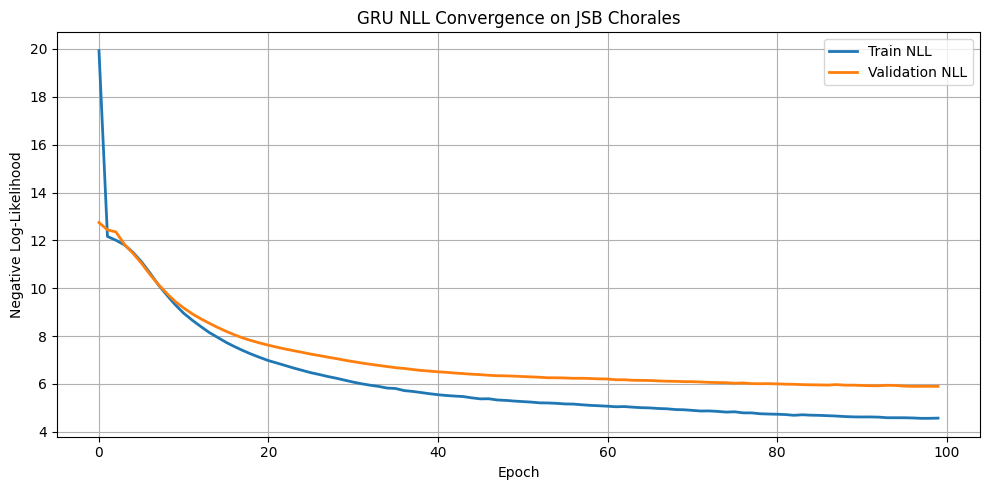

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_nlls, label='Train NLL', linewidth=2)
plt.plot(val_nlls, label='Validation NLL', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("GRU NLL Convergence on JSB Chorales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
plt.savefig("gru_nll_convergence.png", dpi=300)

<Figure size 640x480 with 0 Axes>

In [9]:
test_loader = DataLoader(GRUData(test_data), batch_size=batch_size, collate_fn=collate_fn)

def evaluate_test(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            mask = (y.sum(dim=-1) != 0).float()
            loss = nll_loss(y_pred, y, mask)
            total_loss += loss.item()
    return total_loss / len(dataloader)

test_nll = evaluate_test(model, test_loader, device)
print(f"Final Test NLL = {test_nll:.4f}")


Final Test NLL = 6.0157
